In [12]:
from train_eval import train, evaluate
from model import get_model
from data_utils import get_cifar100_loaders
import torch.nn as nn
import torch.optim as optim
import torch
train_loader, test_loader = get_cifar100_loaders(batch_size=128)
model = get_model('vgg11_bn', pretrained=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, train_top1, train_top5 = train(model, train_loader, optimizer, criterion, epochs=20)
evaluate(model, test_loader, criterion)

torch.save(model.state_dict(), "vgg11_bn_finetuned.pth")
print("Model saved as vgg11_bn_finetuned.pth")


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch [1/20] | Loss: 4.3205 | Top-1: 3.16% | Top-5: 13.64%
Epoch [2/20] | Loss: 3.8478 | Top-1: 7.69% | Top-5: 28.22%
Epoch [3/20] | Loss: 3.5628 | Top-1: 11.71% | Top-5: 37.96%
Epoch [4/20] | Loss: 3.3178 | Top-1: 15.64% | Top-5: 45.39%
Epoch [5/20] | Loss: 3.1338 | Top-1: 19.32% | Top-5: 50.71%
Epoch [6/20] | Loss: 2.9732 | Top-1: 22.72% | Top-5: 55.45%
Epoch [7/20] | Loss: 2.8269 | Top-1: 26.16% | Top-5: 59.16%
Epoch [8/20] | Loss: 2.7084 | Top-1: 28.55% | Top-5: 62.13%
Epoch [9/20] | Loss: 2.5893 | Top-1: 31.15% | Top-5: 65.08%
Epoch [10/20] | Loss: 2.4986 | Top-1: 33.35% | Top-5: 67.00%
Epoch [11/20] | Loss: 2.4079 | Top-1: 35.60% | Top-5: 69.12%
Epoch [12/20] | Loss: 2.3178 | Top-1: 37.25% | Top-5: 71.12%
Epoch [13/20] | Loss: 2.2403 | Top-1: 39.40% | Top-5: 72.58%
Epoch [14/20] | Loss: 2.1624 | Top-1: 40.99% | Top-5: 74.37%
Epoch [15/20] | Loss: 2.0949 | Top-1: 42.66% | Top-5: 75.74%
Epoch [16/20] | Loss: 2.0246 | Top-1: 44.57% | Top-5: 76.95%
Epoch [17/20] | Loss: 1.9707 | Top-

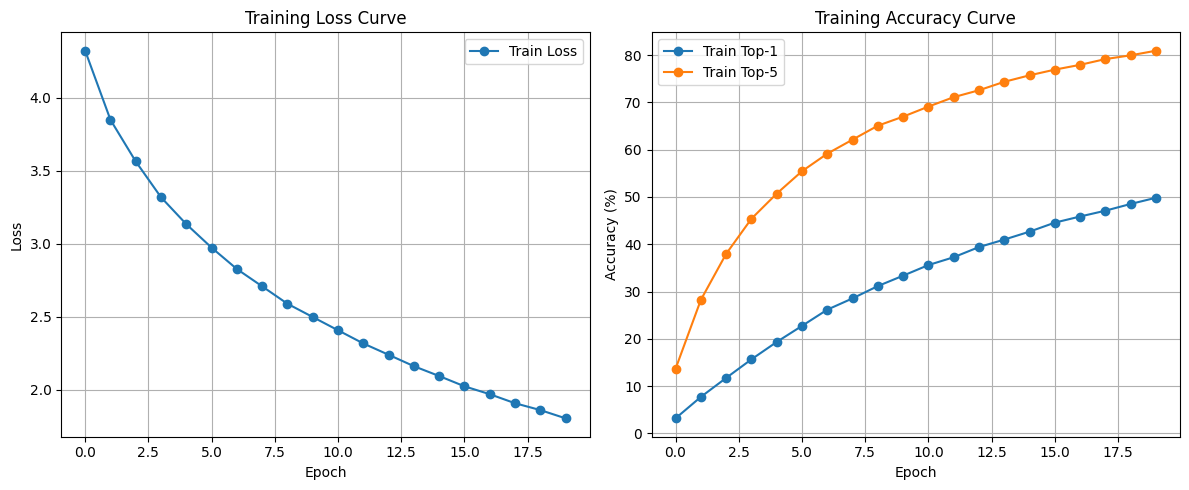

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_top1, label='Train Top-1', marker='o')
plt.plot(train_top5, label='Train Top-5', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
from data_utils import get_cifar100_loaders
from model import get_model
from train_eval import evaluate
from train_kd import train_kd, KDLoss
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_cifar100_loaders(batch_size=128, num_workers=2)

teacher = get_model('vgg16_bn', pretrained=True, num_classes=100)
student = get_model('vgg11_bn', pretrained=False, num_classes=100)

teacher.to(device)
student.to(device)

ce_criterion = nn.CrossEntropyLoss()
kd_criterion = KDLoss(ce_criterion, alpha=0.6, T=3.0)
optimizer = optim.Adam(student.parameters(), lr=1e-4)

student, epoch_losses, epoch_ce, epoch_kd, epoch_top1, epoch_top5 = train_kd(student=student,
                   teacher=teacher,
                   train_loader=train_loader,
                   optimizer=optimizer,
                   kd_criterion=kd_criterion,
                   epochs=20,
                   device=device,
                   save_path='student_kd_final.pth',
                   log_every=20)

avg_loss, top1, top5 = evaluate(student, test_loader, ce_criterion, device=device)
print(f"Test -> Loss: {avg_loss:.4f}, Top1: {top1:.2f}%, Top5: {top5:.2f}%")

torch.save(student.state_dict(), "distilled_student.pth")
print("Distilled Student Saved")


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch 1 Batch 20/391 | Loss 16.2246 (CE 4.6039, KD 23.9718) | Top1 1.25% Top5 5.82%
Epoch 1 Batch 40/391 | Loss 16.2046 (CE 4.6015, KD 23.9401) | Top1 1.37% Top5 6.43%
Epoch 1 Batch 60/391 | Loss 16.1772 (CE 4.5921, KD 23.9006) | Top1 1.51% Top5 7.02%
Epoch 1 Batch 80/391 | Loss 16.1233 (CE 4.5713, KD 23.8246) | Top1 1.66% Top5 7.36%
Epoch 1 Batch 100/391 | Loss 16.0720 (CE 4.5729, KD 23.7381) | Top1 1.62% Top5 7.41%
Epoch 1 Batch 120/391 | Loss 16.0237 (CE 4.5552, KD 23.6693) | Top1 1.63% Top5 7.90%
Epoch 1 Batch 140/391 | Loss 15.9406 (CE 4.5360, KD 23.5437) | Top1 1.71% Top5 8.15%
Epoch 1 Batch 160/391 | Loss 15.8621 (CE 4.5232, KD 23.4214) | Top1 1.70% Top5 8.24%
Epoch 1 Batch 180/391 | Loss 15.8015 (CE 4.5091, KD 23.3297) | Top1 1.83% Top5 8.57%
Epoch 1 Batch 200/391 | Loss 15.7507 (CE 4.4988, KD 23.2519) | Top1 1.90% Top5 8.88%
Epoch 1 Batch 220/391 | Loss 15.6945 (CE 4.4843, KD 23.1679) | Top1 2.03% Top5 9.26%
Epoch 1 Batch 240/391 | Loss 15.6365 (CE 4.4744, KD 23.0780) | Top1 2

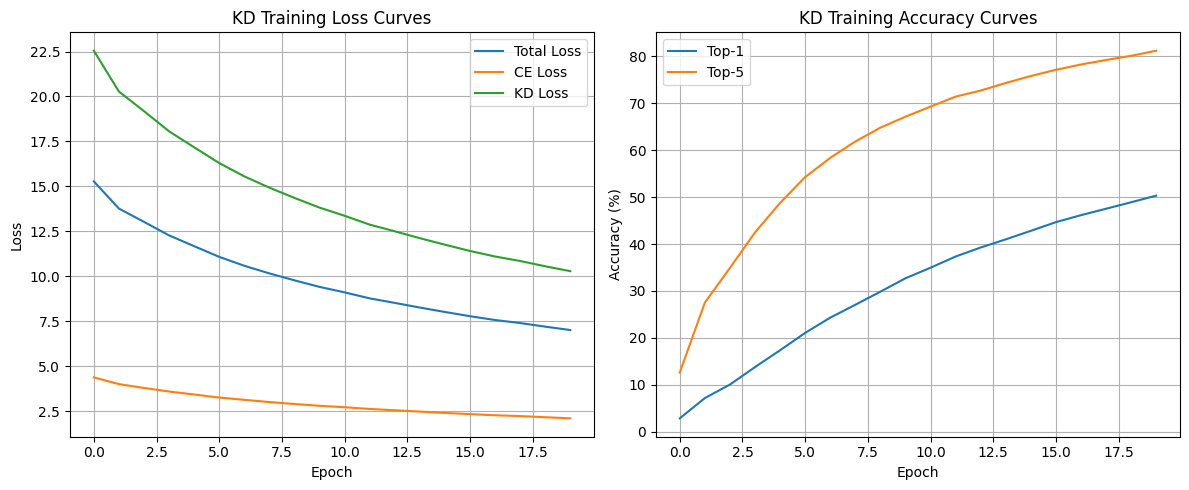

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_losses, label='Total Loss')
plt.plot(epoch_ce, label='CE Loss')
plt.plot(epoch_kd, label='KD Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KD Training Loss Curves')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(epoch_top1, label='Top-1')
plt.plot(epoch_top5, label='Top-5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('KD Training Accuracy Curves')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()